In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

from time import time
import pandas as pd
import numpy as np

os.environ['OPENAI_KEY_SAE'] = os.environ['OAI_GENERAL']

df = pd.read_json(os.path.join('..', "demo-data", "yelp-demo-val-2K.json"), lines=True)

texts = df['text'].tolist()
labels = df['stars'].values

def abbrev_model_name(full_model):
    if '/' in full_model:
        full_model = full_model.split('/')[-1]
    model_name, thinking = full_model.split('_')
    thinking = thinking.split('=')[1]
    return (model_name, thinking)

## Evaluating autointerp: compute interpretation fidelities

In [2]:
import os
import pickle

base_dir = os.path.join('/nas/ucb/rmovva/data/hypothesaes')
fidelities = pickle.load(open(os.path.join(base_dir, 'local_llm_experiments', 'results', 'fidelities_1024_32.pkl'), "rb"))

metric = 'correlation'

# Get metric values for each model
model_metrics = {}
for model, model_fidelities in fidelities.items():
    metrics = []
    for neuron_idx, neuron_data in model_fidelities.items():
        if neuron_data:  # Skip empty neurons
            # Get max metric across all interpretations for this neuron
            neuron_metrics = [interp_data[metric] for interp_data in neuron_data.values()]
            if neuron_metrics:
                metrics.append(max(neuron_metrics))
    model_metrics[model] = metrics

sorted_models = sorted(model_metrics.keys(), key=lambda m: np.median(model_metrics[m]) if model_metrics[m] else 0, reverse=True)

In [3]:
# Get all models including the missing one
all_models = ["gpt-4.1_think=False", "Qwen/Qwen3-32B-AWQ_think=True", "Qwen/Qwen3-14B_think=True", "Qwen/Qwen3-8B_think=True", "Qwen/Qwen3-32B-AWQ_think=False"]

# Get all neurons that have data across models
all_neurons = set()
for model in all_models:
    if model in fidelities:
        all_neurons.update(fidelities[model].keys())

# Sample 5 random neurons
sample_neurons = np.random.choice(list(all_neurons), size=min(5, len(all_neurons)), replace=False)

for neuron_idx in sample_neurons:
    print(f"Neuron {neuron_idx}:")
    for model in all_models:
        if model in fidelities and neuron_idx in fidelities[model] and fidelities[model][neuron_idx]:
            # Find best interpretation for this neuron and model
            best_interp = max(fidelities[model][neuron_idx].items(), key=lambda x: x[1][metric])
            model_name, thinking = abbrev_model_name(model)
            print(f"- {model_name} (thinking={thinking}): {best_interp[0]} (corr={best_interp[1][metric]:.3f})")
    print()


Neuron 543:
- gpt-4.1 (thinking=False): mentions the presence of foreign or hazardous objects (such as plastic, bone, or shrimp) found in food or dishes (corr=0.813)
- Qwen3-32B-AWQ (thinking=True): mentions finding foreign objects in food (corr=0.801)
- Qwen3-14B (thinking=True): mentions presence of unintended foreign objects in food (corr=0.829)
- Qwen3-8B (thinking=True): mentions foreign objects in food (corr=0.817)
- Qwen3-32B-AWQ (thinking=False): mentions finding foreign objects in food, such as plastic, hair, or unidentified materials (corr=0.770)

Neuron 894:
- gpt-4.1 (thinking=False): mentions experiences at Popeyes, specifically discussing details about visiting or ordering from this restaurant (corr=0.925)
- Qwen3-32B-AWQ (thinking=True): mentions Popeyes (corr=0.837)
- Qwen3-14B (thinking=True): mentions Popeyes Louisiana Kitchen or Popeyes in the text (corr=0.872)
- Qwen3-8B (thinking=True): mentions Popeyes (corr=0.837)
- Qwen3-32B-AWQ (thinking=False): mentions specif

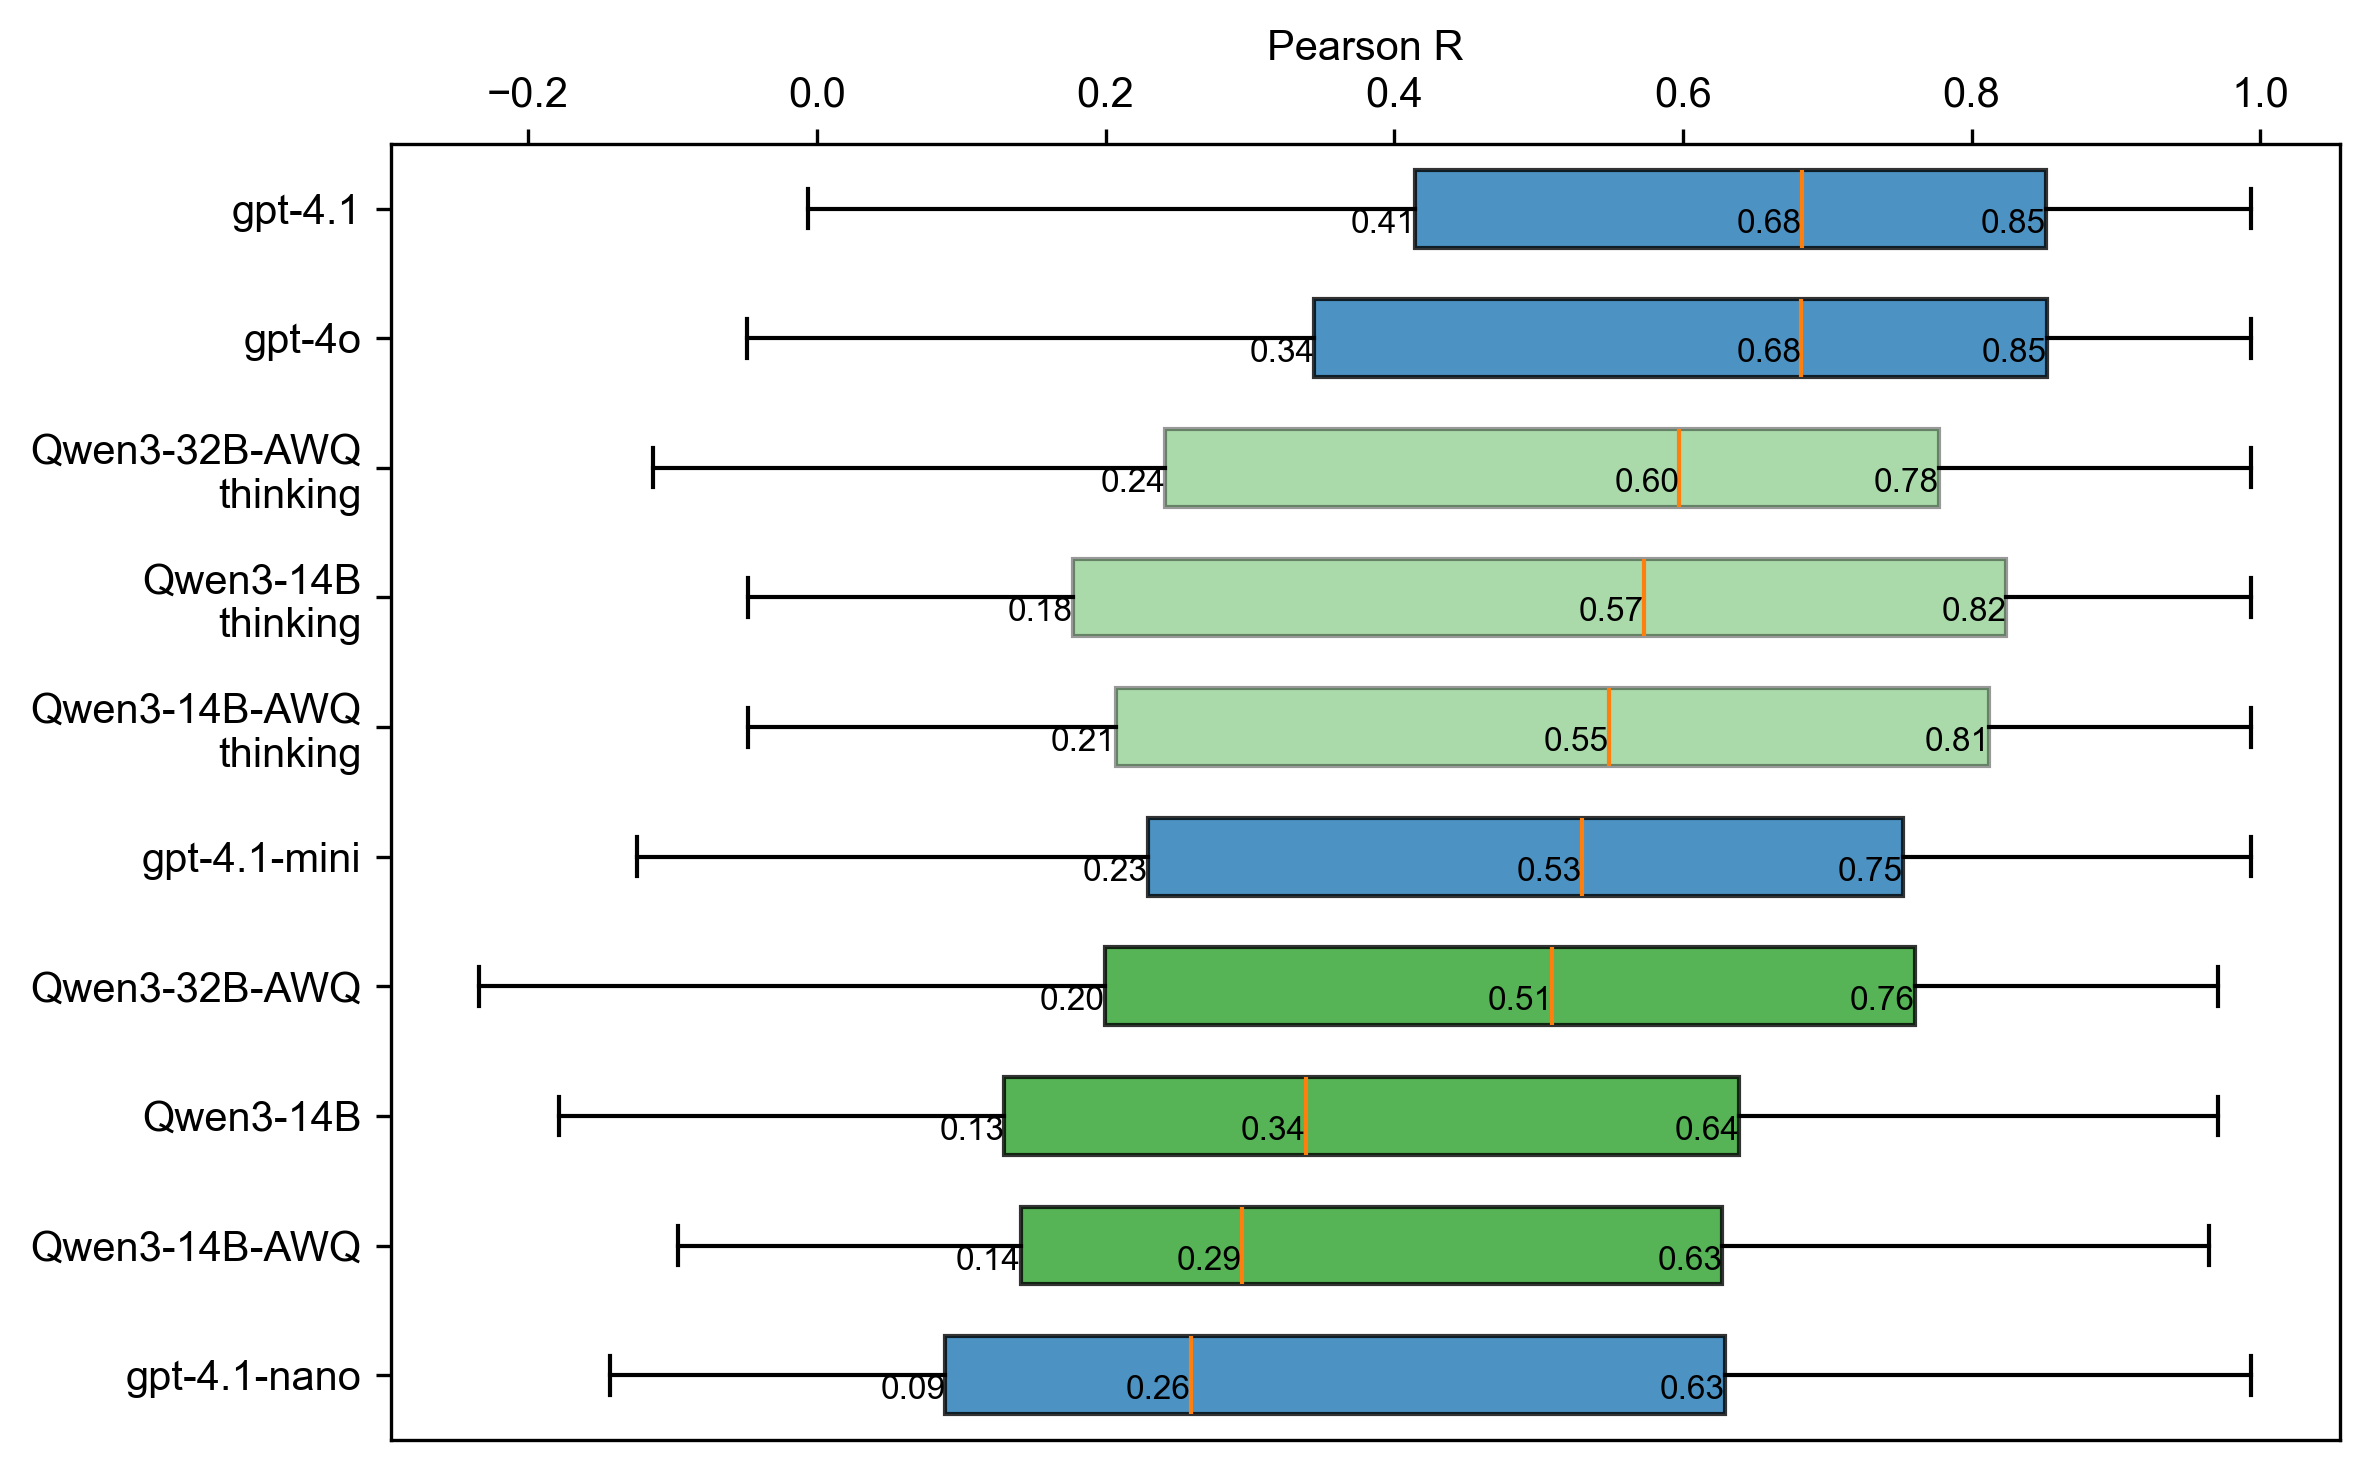

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

data_for_plot = []
model_labels = []
alphas = []
colors = []
for model in sorted_models:
    if '8B' in model:
        continue
    model_name, thinking = abbrev_model_name(model)
    alpha = 0.4 if thinking == 'True' else 0.8
    label = f"{model_name}\nthinking" if thinking == 'True' else model_name
    color = 'C0' if 'gpt' in model_name.lower() else 'C2'
    data_for_plot.extend(model_metrics[model])
    model_labels.extend([label] * len(model_metrics[model]))
    alphas.extend([alpha] * len(model_metrics[model]))
    colors.extend([color] * len(model_metrics[model]))

plot_df = pd.DataFrame({'Model': model_labels, metric.upper(): data_for_plot, 'Alpha': alphas, 'Color': colors})

plt.figure(figsize=(8, len(plot_df['Model'].unique()) // 2), dpi=300)
ax = plt.gca()
for i, model_name in enumerate(plot_df['Model'].unique()):
    model_data = plot_df[plot_df['Model'] == model_name]
    alpha = model_data['Alpha'].iloc[0]
    color = model_data['Color'].iloc[0]
    box_data = model_data[metric.upper()]
    bp = ax.boxplot(box_data, positions=[i], widths=0.6, patch_artist=True, vert=False)
    bp['boxes'][0].set_alpha(alpha)
    if color:
        bp['boxes'][0].set_facecolor(color)
    median = np.median(box_data)
    q25 = np.percentile(box_data, 25)
    q75 = np.percentile(box_data, 75)
    ax.text(median, i, f'{median:.2f}', ha='right', va='top', fontsize=8)
    ax.text(q25, i, f'{q25:.2f}', ha='right', va='top', fontsize=8)
    ax.text(q75, i, f'{q75:.2f}', ha='right', va='top', fontsize=8)

ax.set_yticklabels(plot_df['Model'].unique(), rotation=0, ha='right')
ax.set_xlabel("Pearson R")

# Labels on the top of the plot
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.show()


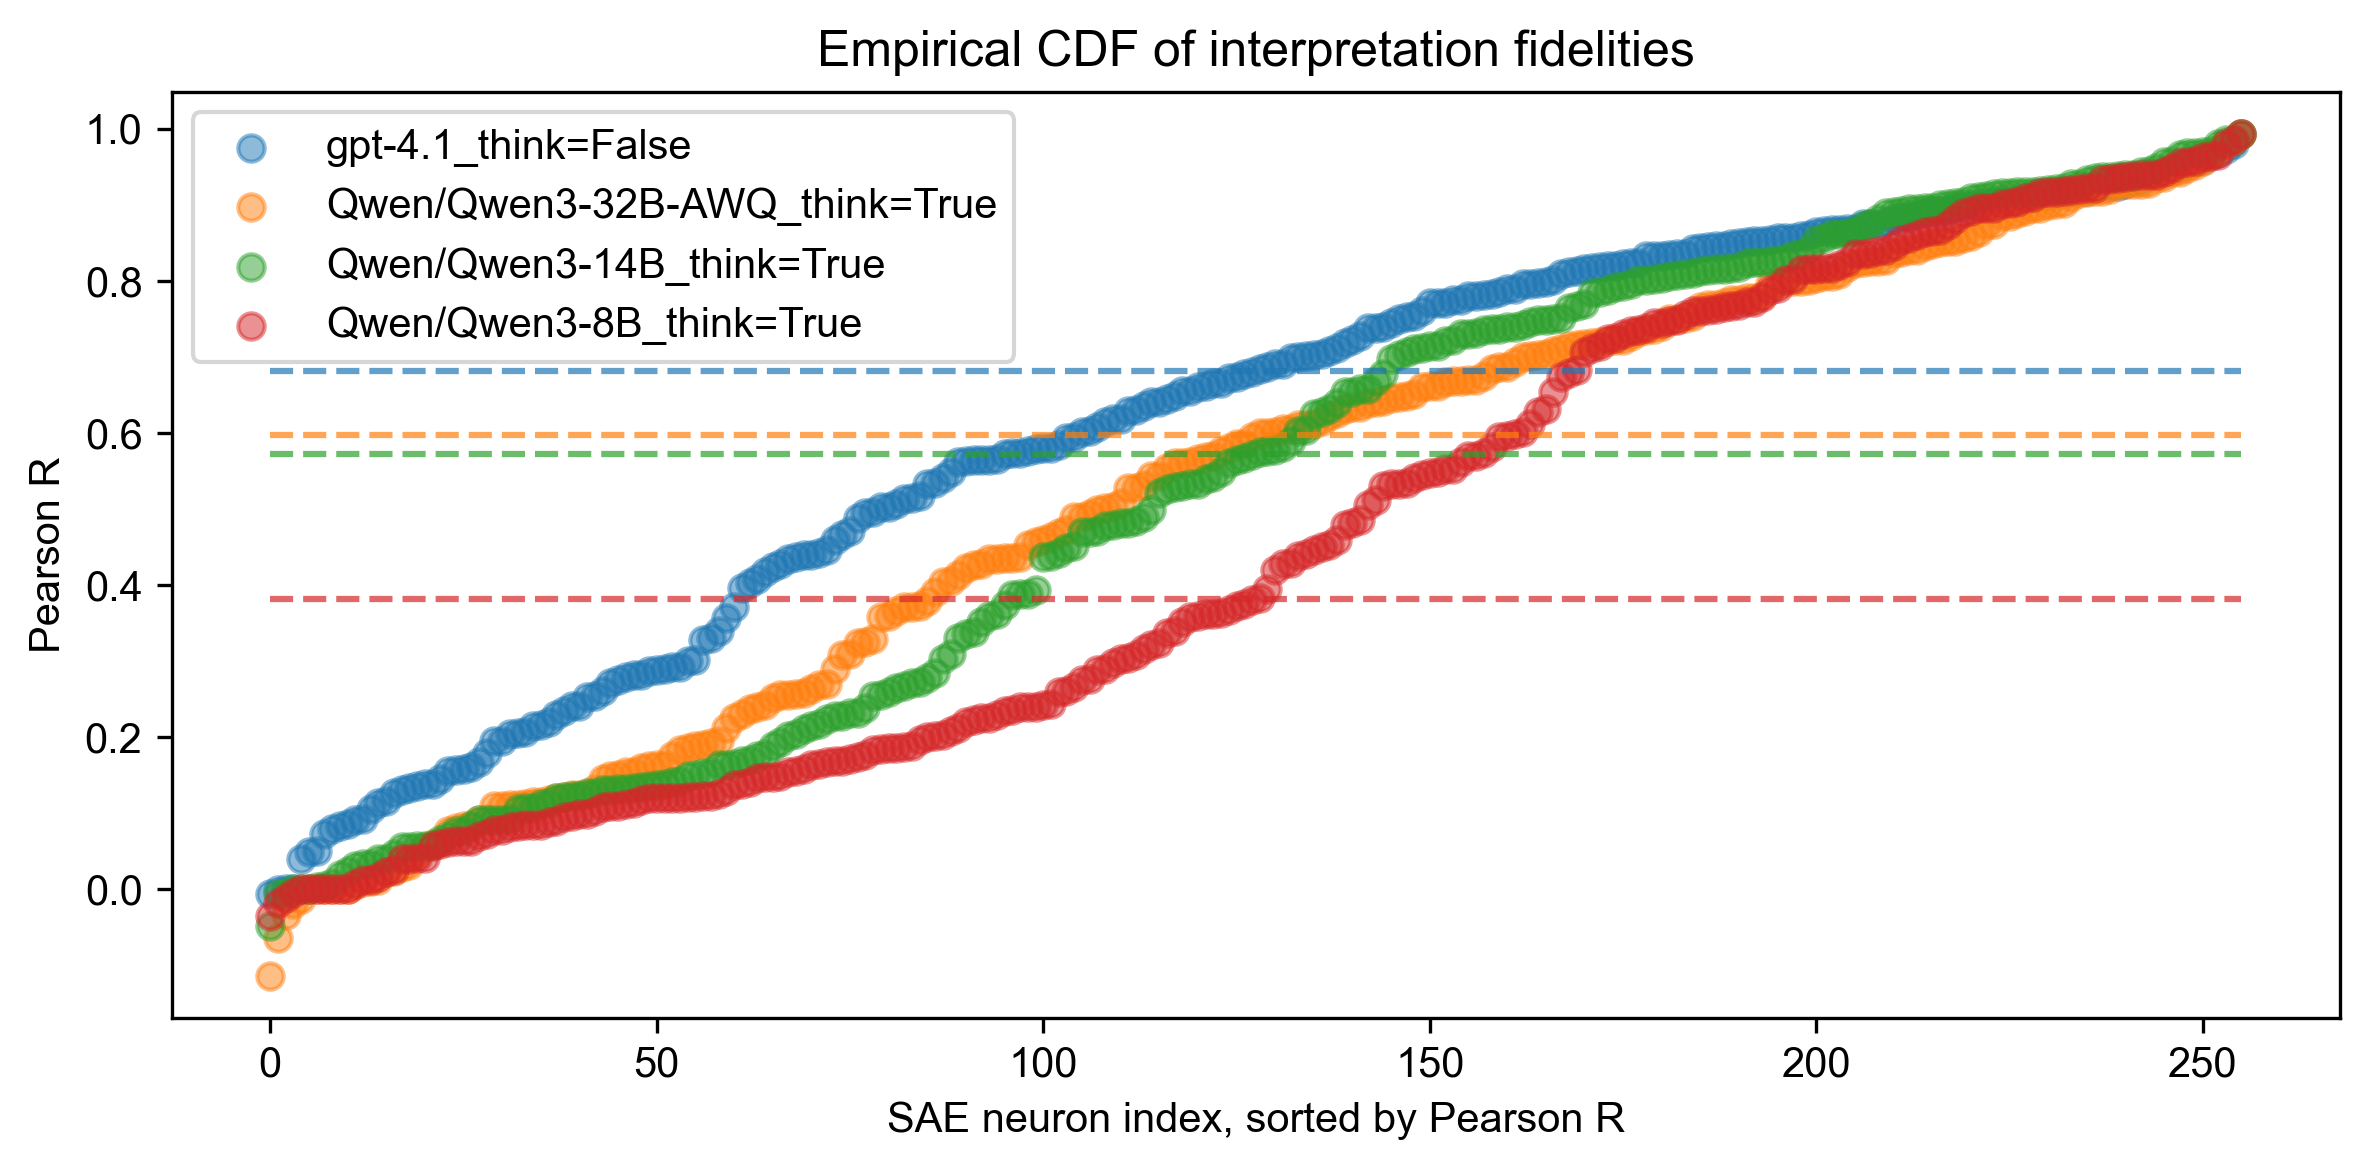

In [5]:
# 1) choose models -----------------------------------------------------------
reference = "gpt-4.1_think=False"            # sorting model
# reference = "Qwen/Qwen3-32B-AWQ_think=True"
others    = ["Qwen/Qwen3-32B-AWQ_think=True", "Qwen/Qwen3-14B_think=True", "Qwen/Qwen3-8B_think=True"]     # models to compare
models    = [reference] + others

# Sort by reference model or individually
sort_by_reference = False  # Set to False to sort each model individually

# 2) load data ---------------------------------------------------------------
data = model_metrics

missing = [m for m in models if m not in data]
if missing:
    raise KeyError(f"Models not in model_metrics: {missing}")

# 3) gather F1 vectors -------------------------------------------------------
f1_by_model = {m: data[m] for m in models}

# Sort indices based on flag
if sort_by_reference:
    # Sort all models by reference model performance
    reference_scores = f1_by_model[reference]
    sorted_indices = sorted(range(len(reference_scores)), key=lambda i: reference_scores[i])

# 4) plot --------------------------------------------------------------------
plt.figure(figsize=(8, 4), dpi=300)
colors = plt.cm.tab10.colors

for i, (m, scores) in enumerate(f1_by_model.items()):
    if sort_by_reference:
        # Sort scores according to reference model ordering
        sorted_scores = np.array([scores[idx] for idx in sorted_indices])
    else:
        # Sort each model individually
        sorted_scores = np.array(sorted(scores))
    
    plt.scatter(
        range(len(sorted_scores)),
        sorted_scores,
        s=40,
        alpha=0.5,
        label=m,
        color=colors[i % len(colors)],
    )
    plt.hlines(
        np.median(sorted_scores),
        0,
        len(sorted_scores) - 1,
        ls="--",
        color=colors[i % len(colors)],
        alpha=0.7,
    )

plt.xlabel(f"SAE neuron index, sorted by Pearson R")
plt.ylabel("Pearson R")
plt.title("Empirical CDF of interpretation fidelities")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
from scipy.stats import ttest_rel

def compare_models(model1_key, model2_key, label1, label2):
    scores1 = data[model1_key]
    scores2 = data[model2_key]
    t_stat, p_value = ttest_rel(scores1, scores2)
    mean_diff = np.mean(scores1) - np.mean(scores2)
    print(f"{label1} vs {label2}: p={p_value:.3f}, sig={p_value < 0.05}, mean_diff={mean_diff:.3f}")

compare_models('gpt-4.1_think=False', 'Qwen/Qwen3-14B_think=True', 'GPT-4.1', 'Qwen14B-think')
compare_models('Qwen/Qwen3-14B_think=True', 'Qwen/Qwen3-14B_think=False', 'Qwen14B-think', 'Qwen14B-no-think')
compare_models('Qwen/Qwen3-14B_think=True', 'Qwen/Qwen3-8B_think=True', 'Qwen14B-think', 'Qwen8B-think')
compare_models('Qwen/Qwen3-32B-AWQ_think=True', 'Qwen/Qwen3-32B-AWQ_think=False', 'Qwen32B-AWQ-think', 'Qwen32B-AWQ-no-think')
compare_models('Qwen/Qwen3-14B_think=True', 'Qwen/Qwen3-32B-AWQ_think=True', 'Qwen14B-think', 'Qwen32B-AWQ-think')


GPT-4.1 vs Qwen14B-think: p=0.000, sig=True, mean_diff=0.086
Qwen14B-think vs Qwen14B-no-think: p=0.000, sig=True, mean_diff=0.142
Qwen14B-think vs Qwen8B-think: p=0.000, sig=True, mean_diff=0.072
Qwen32B-AWQ-think vs Qwen32B-AWQ-no-think: p=0.006, sig=True, mean_diff=0.036
Qwen14B-think vs Qwen32B-AWQ-think: p=0.848, sig=False, mean_diff=0.003


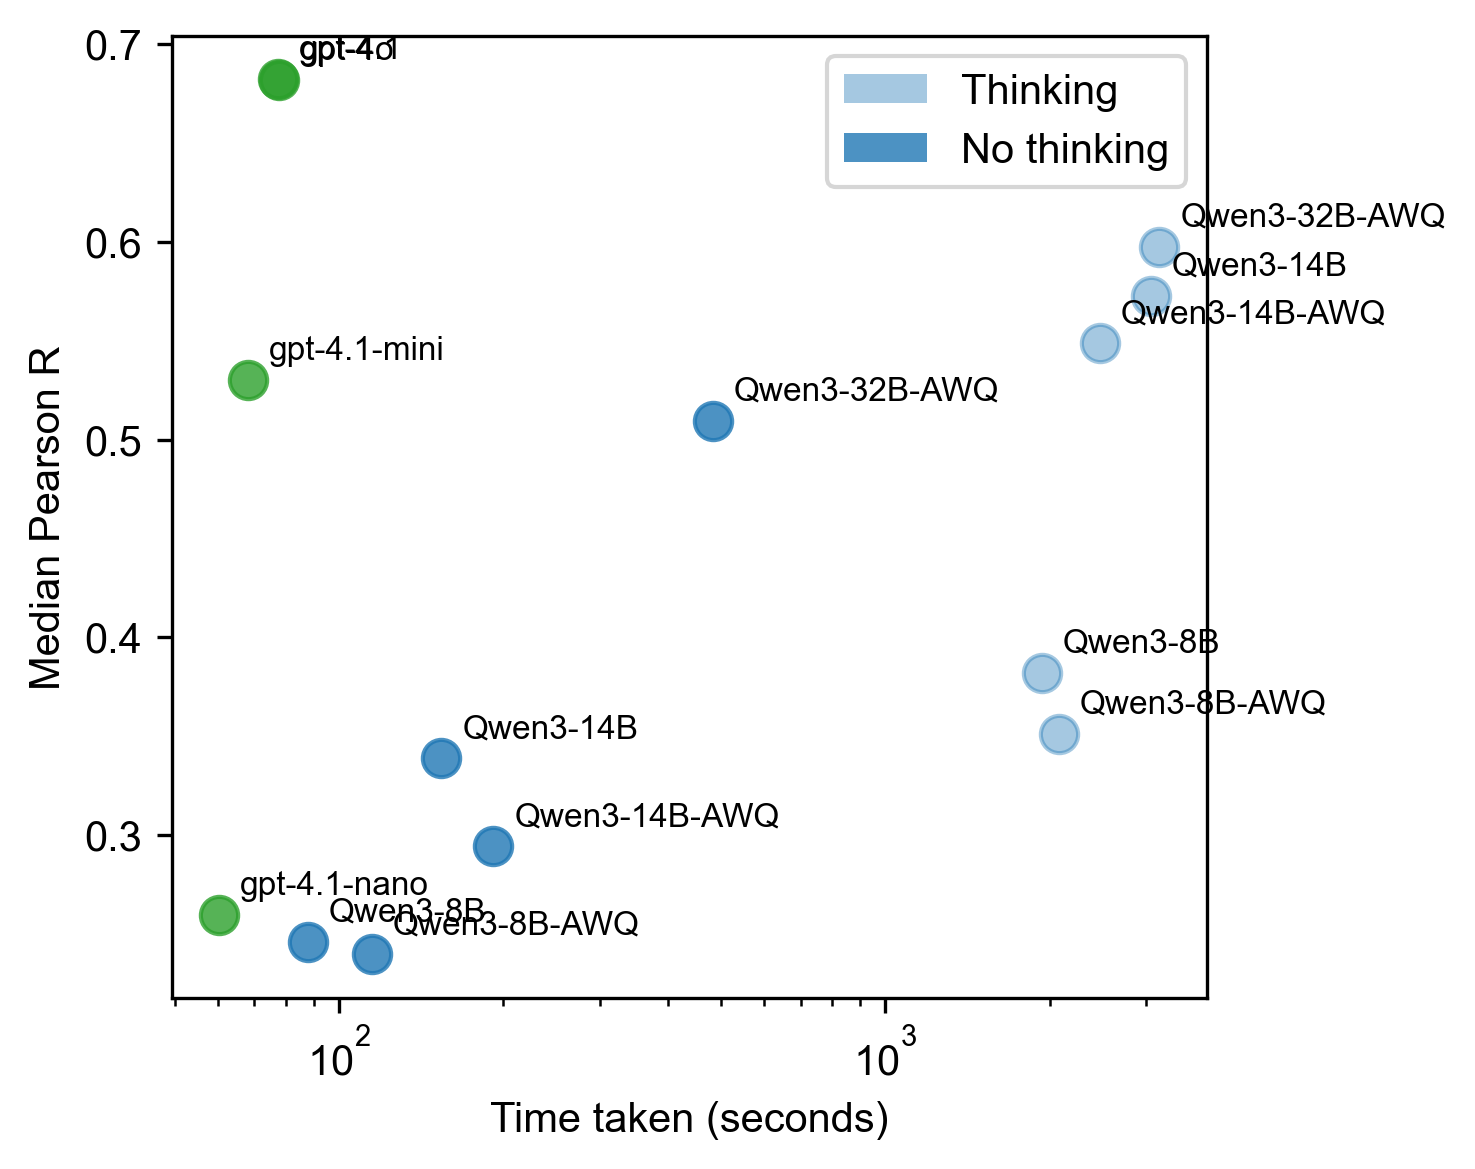

In [8]:
import json

# Load timing data
timing_file = "/nas/ucb/rmovva/data/hypothesaes/local_llm_experiments/results/interpretation_timing_results_1024_32.jsonl"
timing_data = []
with open(timing_file, 'r') as f:
    for line in f:
        timing_data.append(json.loads(line.strip()))

# Create scatter plot of time vs median F1 score
plt.figure(figsize=(5, 4), dpi=300)

for timing_entry in timing_data:
    model_name = timing_entry["model_name"]
    time_taken = timing_entry["time (s)"]
    thinking = timing_entry.get("thinking", False)
    
    # Find corresponding F1 scores
    model_key = f"{model_name}_think={thinking}"
    if model_key in data:
        median_f1 = np.median(data[model_key])
        
        # Set color and opacity based on model type and thinking
        if "gpt" in model_name.lower():
            color = "C2"
            display_name = model_name
        else:  # Qwen models
            color = "C0"
            display_name = model_name.split('/')[-1]  # Take only the part after /
        
        alpha = 0.4 if thinking else 0.8
        
        # Create legend label with thinking status
        legend_label = f"{display_name} ({'thinking' if thinking else 'no thinking'})"
        
        plt.scatter(time_taken, median_f1, color=color, alpha=alpha, 
                   s=80, marker='o', label=legend_label)
        
        # Add text label for each point
        plt.annotate(display_name, (time_taken, median_f1), 
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, ha='left')

plt.xscale('log')
plt.xlabel("Time taken (seconds)")
plt.ylabel("Median Pearson R")
# Create custom legend with just thinking vs non-thinking
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='C0', alpha=0.4, label='Thinking'),
    Patch(facecolor='C0', alpha=0.8, label='No thinking')
]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()


## Evaluating annotation: compare to GPT-4.1

1. Take 5 concepts from Yelp reported in the paper, and 2000 sample texts from the validation set
2. Annotate all texts for all concepts (total: 10000 binary annotation tasks) with GPT-4.1 as "ground truth"
3. Generate annotations using our local LLM code, and compute F1 scores with GPT-4.1
4. Also report time taken with one A6000  

Notes:
- We use a separate script `generate_local_annotations.py` to compute annotations for local LLMs.  
This is because we can't store many LLMs in GPU memory at once, so we run each model sequentially and cache their annotations. This notebook uses the cached annotations.

- We compute annotations for a few other closed OpenAI models in this notebook.

In [3]:
concepts = [
    "uses superlative language to describe the restaurant as the best in a specific category (e.g., 'best lobster roll', 'best bakery', 'best cheesesteaks')",
    "mentions experiences of food causing illness, such as food poisoning, stomach pain, or vomiting",
    "mentions long wait times for seating, food, or service",
    "complains about repeated service errors or unresolved issues despite multiple attempts to address them",
    "complains about poor or rude customer service",
]
texts_to_annotate = texts[:]
tasks = [(text, concept) for text in texts_to_annotate for concept in concepts]

df_annot = pd.DataFrame()

In [4]:
from hypothesaes.annotate import annotate
from hypothesaes.annotate import CACHE_DIR

start = time()
gt_model = 'gpt-4.1'
ground_truth = annotate(tasks, model=gt_model, n_workers=200, max_words_per_example=256, 
                        cache_path=os.path.join(CACHE_DIR, f'test_{gt_model}.json'))

y_gt = np.array([ground_truth[concept][text] for (text, concept) in tasks])
df_annot['ground_truth'] = y_gt

Found 10000 cached items; annotating 0 uncached items


In [5]:
MODELS = [
    "Qwen/Qwen3-0.6B",
    # "google/gemma-3-1b-it",
    "HuggingFaceTB/SmolLM3-3B",
    "meta-llama/Llama-3.2-3B-Instruct",
    "Qwen/Qwen3-4B",
    # "google/gemma-3-4b-it",
    "mistralai/Mistral-7B-Instruct-v0.3",
    "Qwen/Qwen3-8B",
    "meta-llama/Llama-3.1-8B-Instruct",
    # "google/gemma-3-12b-it",
    "Qwen/Qwen3-14B",
]
TEMPERATURES = [0.0]
THINKING_OPTIONS = [True, False]
PROMPT_TEMPLATES = ["annotate-simple", "annotate"]

for model in MODELS:
    for temperature in TEMPERATURES:
        for thinking in THINKING_OPTIONS:
            for prompt_template in PROMPT_TEMPLATES:
                model_key = (model, temperature, thinking, prompt_template)

                cache_path = os.path.join(CACHE_DIR, f'test_{model}_temp={temperature}_think={thinking}_prompt={prompt_template}.json')
                max_tokens = 1000 if thinking else 10
                if not ('Qwen' in model or 'SmolLM3' in model) and thinking:
                    continue
                
                results = annotate(tasks,
                                   use_cache_only=True,
                                   uncached_value=0,
                                   cache_path=cache_path)
                df_annot[model_key] = np.array([results[concept][text] for (text, concept) in tasks])

Found 9995 cached items; mapped 5 uncached items to 0
Found 9987 cached items; mapped 13 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 9989 cached items; mapped 11 uncached items to 0
Found 9996 cached items; mapped 4 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 9880 cached items; mapped 120 uncached items to 0
Found 9984 cached items; mapped 16 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 10000 cached items; mapped 0 uncached items to 0
Found 9939 cached items; mapped 61 uncached items to 0
Found 9979 cached items; mapped 21 uncached items to 0
Found 10000

In [6]:
closed_models = ['gpt-4.1', 'gpt-4.1-mini', 'gpt-4.1-nano']
for model in closed_models:
    for prompt_template in ['annotate-simple', 'annotate']:
        model_key = (model, 0.0, False, prompt_template)
        if model_key in df_annot.columns:
            continue
        results = annotate(tasks, model=model, max_words_per_example=256, max_tokens=10, prompt_template_name=prompt_template, n_workers=100,
                           cache_path=os.path.join(CACHE_DIR, f'test_{model}_{prompt_template}.json'))
        df_annot[model_key] = np.array([results[concept][text] for (text, concept) in tasks])

Found 10000 cached items; annotating 0 uncached items
Found 10000 cached items; annotating 0 uncached items
Found 10000 cached items; annotating 0 uncached items
Found 10000 cached items; annotating 0 uncached items
Found 10000 cached items; annotating 0 uncached items
Found 10000 cached items; annotating 0 uncached items


In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score
from scipy.stats import pearsonr
import pandas as pd

# Create results dataframe
results_data = []
y_true = df_annot['ground_truth'].values

for col in df_annot.columns:
    if col == 'ground_truth':
        continue
    
    y_pred = df_annot[col].values
    
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    correlation, _ = pearsonr(y_true, y_pred)
    
    # Extract components from tuple key
    if isinstance(col, tuple) and len(col) == 4:
        model_name, temperature, thinking, prompt = col
    else:
        # Fallback for non-tuple keys
        model_name = str(col)
        temperature = 0.0
        thinking = False
        prompt = 'unknown'
    
    results_data.append({
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'correlation': correlation,
        'model_name': model_name,
        'temperature': temperature,
        'prompt': prompt,
        'thinking': thinking
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('f1', ascending=False)


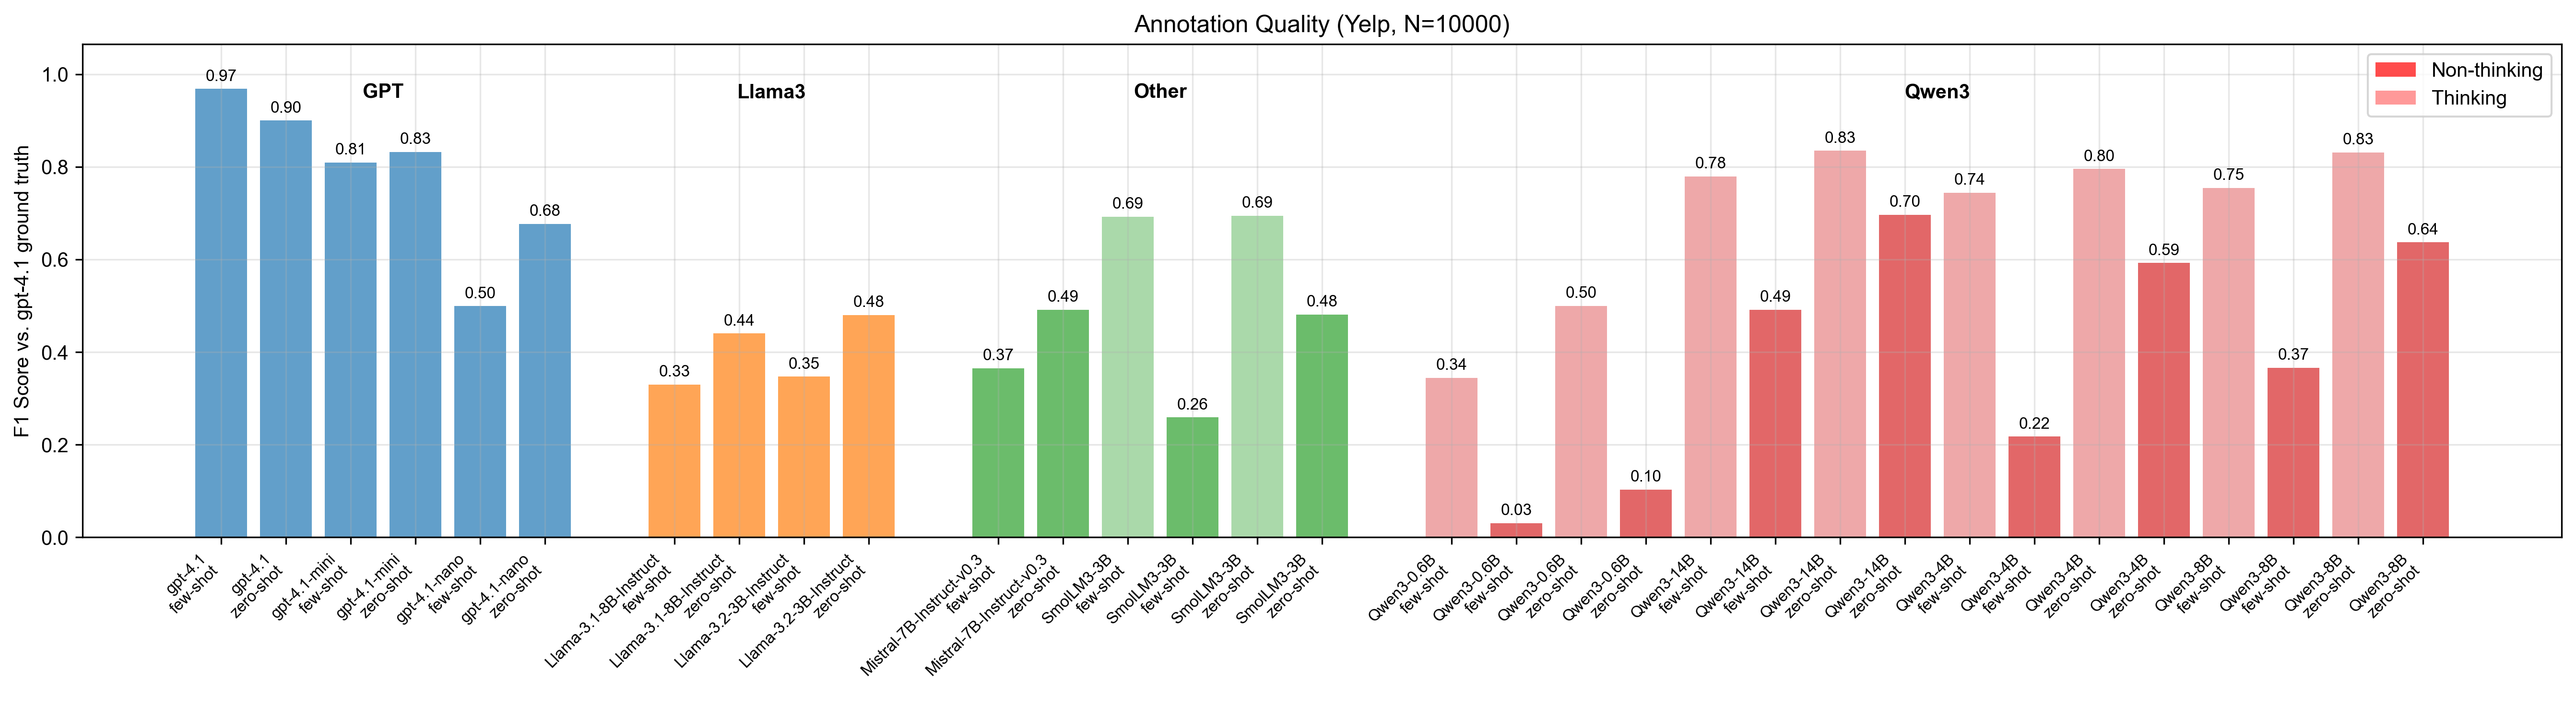

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def model_to_group(row):
    if 'gpt' in row['model_name'].lower():
        return 'GPT'
    # elif row['thinking']:
    #     return 'Reasoning'
    elif 'qwen' in row['model_name'].lower():
        return 'Qwen3'
    elif 'llama' in row['model_name'].lower():
        return 'Llama3'
    elif 'gemma' in row['model_name'].lower():
        return 'Gemma'
    else:
        return 'Other'
    
def model_to_label(row, include_thinking=False):
    label_result = ''
    model_name = row['model_name']
    if '/' in model_name:
        model_name = model_name.split('/')[-1]
    label_result += f'{model_name}'
    prompt = row['prompt']
    if prompt == 'annotate-simple':
        label_result += f'\nzero-shot'
    elif prompt == 'annotate':
        label_result += f'\nfew-shot'
    if include_thinking:
        label_result += f'\nthinking={row["thinking"]}'
    return label_result

# Filter results for temperature=0.0 and exclude simple prompts
filtered_df = results_df[
    (results_df['temperature'] == 0.0) 
    & (~results_df['model_name'].str.contains('gemma'))
    # & (~results_df['prompt'].str.contains('simple', case=False, na=False))
].copy()

# Add display labels
# include_thinking = filtered_df['thinking'].nunique() > 1
include_thinking = False
filtered_df['model_group'] = filtered_df.apply(model_to_group, axis=1)
filtered_df['prompt_label'] = filtered_df.apply(lambda row: model_to_label(row, include_thinking), axis=1)

# Group by model
model_groups = filtered_df.groupby('model_group')

# Create the plot
fig, ax = plt.subplots(figsize=(2 + len(filtered_df) * 0.5, 5), dpi=300)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

x_pos = 0
bar_width = 0.8
group_positions = []
all_f1_values = []
all_labels = []
group_centers = []
for i, (model_label, group_data) in enumerate(model_groups):
    color = colors[i % len(colors)]
    
    # Sort group data alphabetically by prompt_label
    group_data_sorted = group_data.sort_values('prompt_label')
    
    group_f1_scores = group_data_sorted['f1'].values
    group_positions.extend(range(x_pos, x_pos + len(group_data_sorted)))
    all_f1_values.extend(group_f1_scores)
    
    # Use prompt labels for x-axis
    prompt_labels = group_data_sorted['prompt_label'].values
    all_labels.extend(prompt_labels)
    
    # Calculate group center for group label
    group_center = x_pos + (len(group_data_sorted) - 1) / 2
    group_centers.append((group_center, model_label))
    
    # Plot vertical bars for this group with different opacity based on thinking
    for j, (idx, row) in enumerate(group_data_sorted.iterrows()):
        alpha = 0.4 if row['thinking'] else 0.7
        bar = ax.bar(x_pos + j, row['f1'], bar_width, color=color, alpha=alpha)
        
        # Add value labels on bars
        ax.text(bar[0].get_x() + bar[0].get_width()/2, bar[0].get_height() + 0.01,
                f'{row["f1"]:.2f}', ha='center', va='bottom', fontsize=8)
    
    x_pos += len(group_data_sorted) + 1  # Add space between groups

# Customize the plot
ax.set_ylabel('F1 Score vs. gpt-4.1 ground truth')
ax.set_title(f'Annotation Quality (Yelp, N={len(y_true)})')
ax.set_xticks(group_positions)
ax.set_xticklabels(all_labels, fontsize=8, rotation=45, ha='right')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, max(all_f1_values) * 1.1)

# Add legend for thinking vs non-thinking
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.7, label='Non-thinking'),
    Patch(facecolor='red', alpha=0.4, label='Thinking')
]
ax.legend(handles=legend_elements, loc='upper right')


# Add group labels below the x-axis
for center, group_label in group_centers:
    ax.text(center, 0.95 * max(all_f1_values), group_label, 
            ha='center', va='top', fontsize=10, fontweight='bold',
            transform=ax.get_xaxis_transform())

plt.tight_layout()
plt.show()


[autoreload of hypothesaes.interpret_neurons failed: Traceback (most recent call last):
  File "/nas/ucb/rmovva/anaconda3/envs/hypothesaes/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/nas/ucb/rmovva/anaconda3/envs/hypothesaes/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 508, in superreload
    update_generic(old_obj, new_obj)
  File "/nas/ucb/rmovva/anaconda3/envs/hypothesaes/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 405, in update_generic
    update(a, b)
  File "/nas/ucb/rmovva/anaconda3/envs/hypothesaes/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/nas/ucb/rmovva/anaconda3/envs/hypothesaes/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 405, in update_generic
    update(a, b)
  File "/nas/u

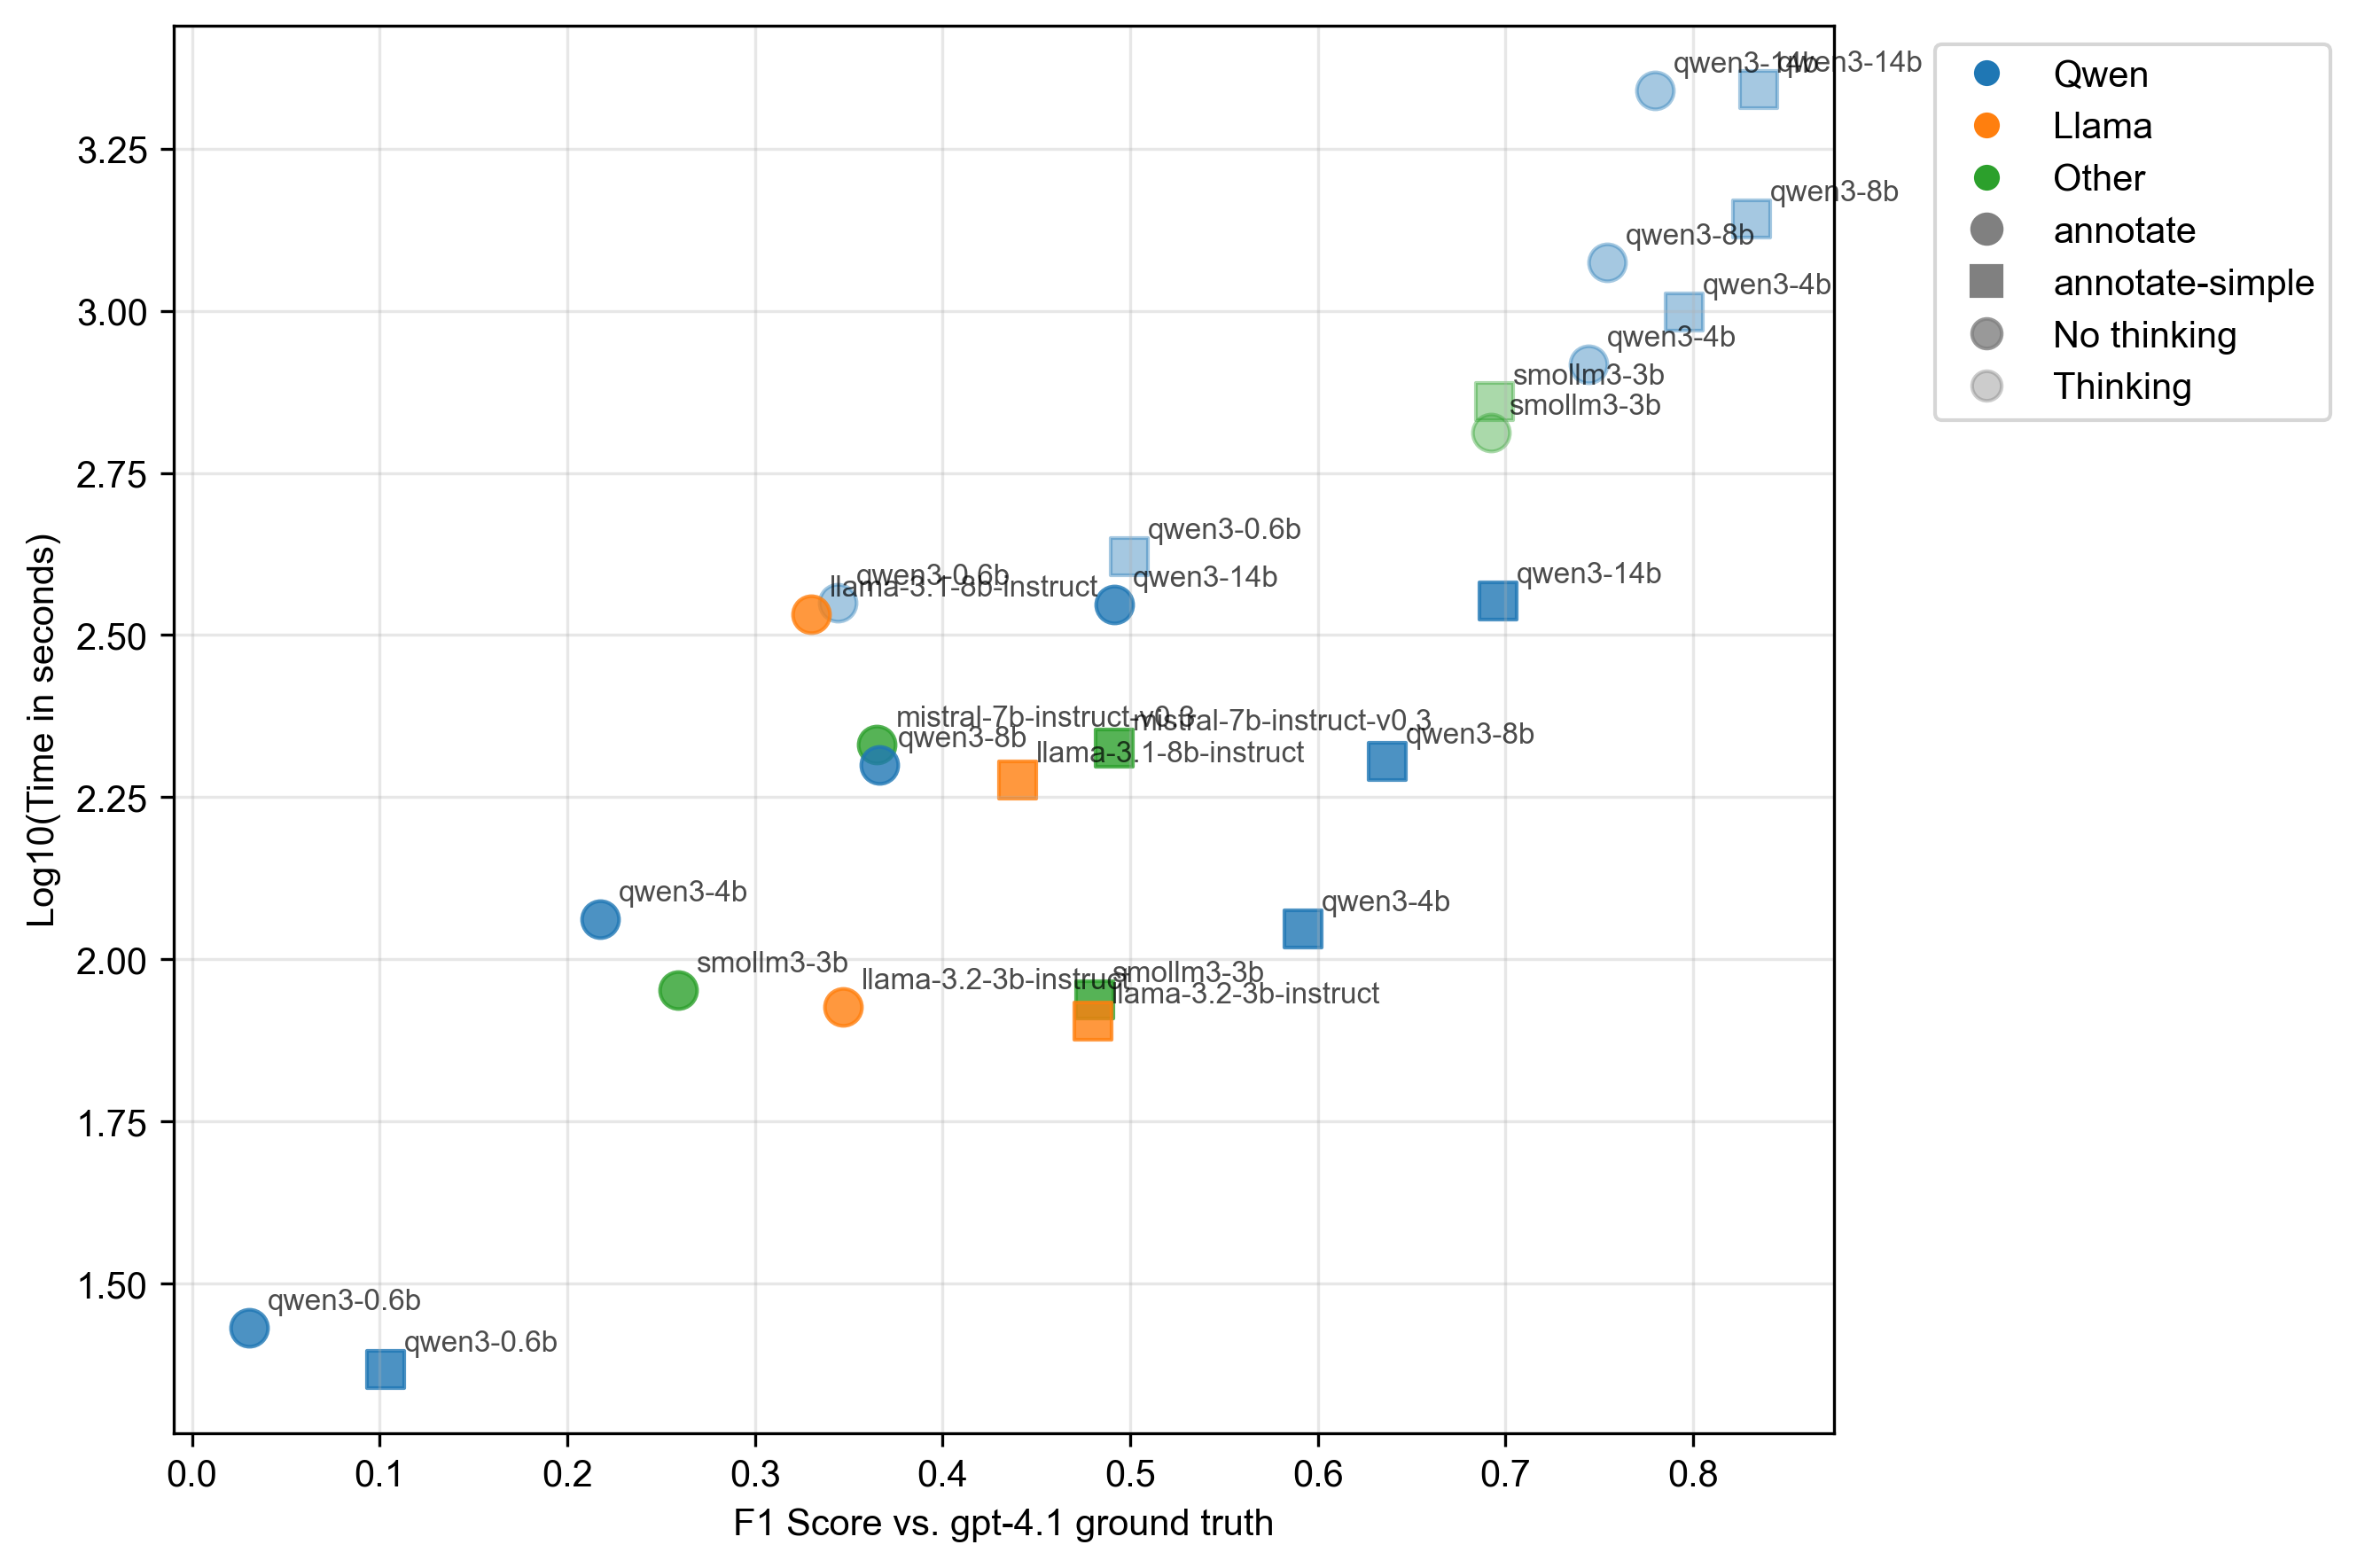

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load timing and results data
df_timing = pd.read_json(os.path.join(CACHE_DIR, "timing_results.jsonl"), lines=True)

# Merge with results data to get F1 scores
df_merged = df_timing.merge(filtered_df, on=['model_name', 'prompt', 'thinking'], how='inner')

# Extract model family and clean model names
def get_model_family(model_name):
    if 'Qwen' in model_name:
        return 'Qwen'
    elif 'Llama' in model_name or 'llama' in model_name:
        return 'Llama'
    else:
        return 'Other'

def clean_model_name(model_name):
    # Extract just the model name without organization prefix
    if '/' in model_name:
        return model_name.split('/')[-1].lower()
    return model_name.lower()

df_merged['model_family'] = df_merged['model_name'].apply(get_model_family)
df_merged['clean_model_name'] = df_merged['model_name'].apply(clean_model_name)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

family_colors = {'Qwen': 'C0', 'Llama': 'C1', 'Other': 'C2'}
prompt_markers = {'annotate': 'o', 'annotate-simple': 's'}
thinking_alpha = {'True': 0.4, 'False': 0.8}

for _, row in df_merged.iterrows():
    color = family_colors[row['model_family']]
    marker = prompt_markers[row['prompt']]
    alpha = thinking_alpha[str(row['thinking'])]
    
    ax.scatter(row['f1'], np.log10(row['time (s)']), 
              color=color, marker=marker, alpha=alpha, s=100)
    
    # Label points with model names
    ax.annotate(row['clean_model_name'], 
               (row['f1'], np.log10(row['time (s)'])),
               xytext=(5, 5), textcoords='offset points',
               fontsize=8, alpha=0.7)

# Customize the plot
ax.set_xlabel('F1 Score vs. gpt-4.1 ground truth')
ax.set_ylabel('Log10(Time in seconds)')
ax.grid(True, alpha=0.3)

# Create legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = []

# Model family colors
for family, color in family_colors.items():
    legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color, markersize=8, label=family))

# Prompt markers
for prompt, marker in prompt_markers.items():
    legend_elements.append(Line2D([0], [0], marker=marker, color='gray', 
                                 markersize=8, label=prompt, linestyle='None'))

# Thinking alpha
legend_elements.append(Line2D([0], [0], marker='o', color='gray', alpha=0.8,
                             markersize=8, label='No thinking', linestyle='None'))
legend_elements.append(Line2D([0], [0], marker='o', color='gray', alpha=0.4,
                             markersize=8, label='Thinking', linestyle='None'))

ax.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()


## Get SAE activations for interpretation

In [42]:
base_dir = os.path.join('/nas/ucb/rmovva/data/hypothesaes', 'hypothesis-generation-data', 'yelp')
train_df = pd.read_json(os.path.join(base_dir, "train-200K.json"), lines=True)
val_df = pd.read_json(os.path.join(base_dir, "val-10K.json"), lines=True)

texts = train_df['text'].tolist()
labels = train_df['stars'].values
val_texts = val_df['text'].tolist() # These are only used for early stopping of SAE training, so we don't need labels.

In [43]:
from hypothesaes import get_local_embeddings

EMBEDDER = "nomic-ai/modernbert-embed-base" # Huggingface model, will run locally
CACHE_NAME = f"yelp_quickstart_{EMBEDDER}"

text2embedding = get_local_embeddings(texts + val_texts, model=EMBEDDER, batch_size=256, cache_name=CACHE_NAME)
embeddings = np.stack([text2embedding[text] for text in texts])

train_embeddings = np.stack([text2embedding[text] for text in texts])
val_embeddings = np.stack([text2embedding[text] for text in val_texts])

Loaded model nomic-ai/modernbert-embed-base to cuda


Processing chunks:   0%|          | 0/5 [00:00<?, ?it/s]

Chunk 0:   0%|          | 0/196 [00:00<?, ?it/s]

Saved 49997 embeddings to /home/rmovva/HypotheSAEs/emb_cache/yelp_quickstart_nomic-ai/modernbert-embed-base/chunk_000.npy


Chunk 1:   0%|          | 0/196 [00:00<?, ?it/s]

Saved 49998 embeddings to /home/rmovva/HypotheSAEs/emb_cache/yelp_quickstart_nomic-ai/modernbert-embed-base/chunk_001.npy


Chunk 2:   0%|          | 0/196 [00:00<?, ?it/s]

Saved 49999 embeddings to /home/rmovva/HypotheSAEs/emb_cache/yelp_quickstart_nomic-ai/modernbert-embed-base/chunk_002.npy


Chunk 3:   0%|          | 0/196 [00:00<?, ?it/s]

Saved 50000 embeddings to /home/rmovva/HypotheSAEs/emb_cache/yelp_quickstart_nomic-ai/modernbert-embed-base/chunk_003.npy


Chunk 4:   0%|          | 0/40 [00:00<?, ?it/s]

Saved 10000 embeddings to /home/rmovva/HypotheSAEs/emb_cache/yelp_quickstart_nomic-ai/modernbert-embed-base/chunk_004.npy


In [48]:
from hypothesaes.quickstart import train_sae

checkpoint_dir = '/nas/ucb/rmovva/data/hypothesaes/local_llm_experiments/checkpoints'
M, K, matryoshka = 1024, 32, [128, 1024]
sae = train_sae(embeddings=embeddings, M=M, K=K, matryoshka_prefix_lengths=matryoshka, checkpoint_dir=checkpoint_dir, val_embeddings=val_embeddings, n_epochs=50, patience=3, overwrite_checkpoint=True)
activations = sae.get_activations(embeddings)

np.save(os.path.join(checkpoint_dir, f'activations_{M}_{K}.npy'), activations)
print(activations.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

Saved model to /nas/ucb/rmovva/data/hypothesaes/local_llm_experiments/checkpoints/SAE_matryoshka_M=1024_K=32_prefixes=128-1024.pt


Computing activations (batchsize=16384):   0%|          | 0/13 [00:00<?, ?it/s]

(200000, 1024)
